### Step 1: Drawing empirical means and covariances

In [119]:

from typing import Tuple as T, Optional as O

import numpy as np
import pandas as pd
from sklearn.covariance import LedoitWolf
from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize, Bounds
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples


from tqdm.notebook import tqdm

### Step 2: Denoising

In [120]:
def fitKDE(obs, bandwidth=.25, kernel='gaussian', x=None):
    """
    по сути генерируем функцию плотности на основе наблюдений `obs`
    а затем возвращаем вероятности каждой из точек
    """

    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated

    # observations to column vector
    obs = obs.reshape(-1, 1) if len(obs.shape) == 1 else obs
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(obs)

    # if x were not passed, then we use unique observations
    x = np.unique(obs).reshape(-1, 1) if x is None else x
    x = x.reshape(-1, 1) if len(x.shape) == 1 else x

    logprob = kde.score_samples(x)  # log(density)
    pdf = pd.Series(np.exp(logprob), index=x.flatten())
    return pdf


def mpPDF(var, q, pts):
    """Marcenko-Pastur pdf"""
    # q=T/N
    var = var[0]
    eigen_min = var * (1 - (1 / q)**.5)**2
    eigen_max = var * (1 + (1 / q)**.5)**2

    eigen_values = np.linspace(eigen_min, eigen_max, pts)
    pdf = q / (2 * np.pi * var * eigen_values) * \
        ((eigen_max - eigen_values) * (eigen_values-eigen_min))**.5
        
    pdf = pd.Series(pdf, index=eigen_values.flatten())
    return pdf


def errPDFs(var, eigen_values, q, bandwidth, pts=1000):
    # Fit error
    pdf0 = mpPDF(var, q, pts)  # theoretical pdf
    pdf1 = fitKDE(eigen_values, bandwidth,
                  x=pdf0.index.values)  # empirical pdf
    sse = np.sum((pdf1 - pdf0)**2)
    return sse


def find_max_eigen_values(eigen_values, q, bandwidth):
    """ Точка входа 

    This function uses a Kernel Density Estimate (KDE) algorithm to fit the
    Marcenko-Pastur distribution to the empirical distribution of eigenvalues.
    This has the effect of separating noise-related eigenvalues from 
    signal-related eigenvalues.
    """
    # Find max random eVal by fitting Marcenko's dist to the empirical one
    # this is done to define variance in order to use formula for maximum 
    # eigen value
    
    out = minimize(
        lambda *x: errPDFs(*x),
        np.array([0.5]),
        args=(eigen_values, q, bandwidth),
        bounds=Bounds(1E-5, 1-1E-5)
    )
    
    var = out['x'][0] if out['success'] else 1
    eMax = var * (1 + (1/q)**.5)**2
    
    # print('OPTIMIZED: ', var, eMax)
    return eMax


### Step 3: Estimating $\hat\omega^*$ from $\{\hat\mu, \hat V\}$

Implementation of NCO algorithm

In [121]:


def clusterKMeansBase(corr0: np.ndarray, maxNumClusters=None, n_init: int = 10):
    dist, silh = ((1 - corr0.fillna(0)) /
                  2.)**.5, pd.Series()  # distance matrix

    if maxNumClusters is None:
        maxNumClusters = corr0.shape[0] / 2

    for init in range(n_init):
        for i in range(2, maxNumClusters + 1):  # find optimal num clusters
            kmeans_ = KMeans(n_clusters=i, n_jobs=1, n_init=1)
            kmeans_ = kmeans_.fit(dist)
            silh_ = silhouette_samples(dist, kmeans_.labels_)
            stat = (silh_.mean()/silh_.std(), silh.mean()/silh.std())
            if np.isnan(stat[1]) or stat[0] > stat[1]:
                silh, kmeans = silh_, kmeans_

    newIdx = np.argsort(kmeans.labels_)
    corr1 = corr0.iloc[newIdx]  # reorder rows
    corr1 = corr1.iloc[:, newIdx]  # reorder columns
    clstrs = {
        i: corr0.columns[np.where(kmeans.labels_ == i)[0]].tolist() for
        i in np.unique(kmeans.labels_)}  # cluster members
    silh = pd.Series(silh, index=dist.index)
    return corr1, clstrs, silh


def optPort(cov, mu=None):
    inv = np.linalg.inv(cov)
    ones = np.ones(shape=(inv.shape[0], 1))
    mu = ones if mu is None else mu
    w = np.dot(inv, mu)
    w /= np.dot(ones.T, w)
    return w


def optPort_nco(cov, mu=None, maxNumClusters=None):
    cov = pd.DataFrame(cov)
    if mu is not None:
        mu = pd.Series(mu[:, 0])
    corr1 = cov2corr(cov)
    corr1, clstrs, _ = clusterKMeansBase(corr1, maxNumClusters, n_init=10)
    wIntra = pd.DataFrame(0, index=cov.index, columns=clstrs.keys())
    for i in clstrs:
        cov_ = cov.loc[clstrs[i], clstrs[i]].values
        mu_ = (None if mu is None else mu.loc[clstrs[i]].values.reshape(-1, 1))
        wIntra.loc[clstrs[i], i] = optPort(cov_, mu_).flatten()
    cov_ = wIntra.T.dot(np.dot(cov, wIntra))  # reduce covariance matrix
    mu_ = (None if mu is None else wIntra.T.dot(mu))
    wInter = pd.Series(optPort(cov_, mu_).flatten(), index=cov_.index)
    nco = wIntra.mul(wInter, axis=1).sum(axis=1).values.reshape(-1, 1)
    return nco


### Monte-carlo simulations

In [122]:


def corr2cov(corr: np.ndarray, std: np.ndarray) -> np.ndarray:
    """recovers the covariance matrix from the de-noise correlation matrix"""
    # creating matrix of stds and multiply it by correlations
    # elementwise
    return corr * np.outer(std, std)


def cov2corr(cov: np.ndarray) -> np.ndarray:
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr < -1], corr[corr > 1] = -1, 1  # numerical error
    return corr


def getPCA(matrix: np.ndarray):
    # Get eVal,eVec from a Hermitian matrix
    eigen_values, eigen_vectors = np.linalg.eigh(matrix)
    indices = eigen_values.argsort()[::-1]  # arguments for sorting eVal desc
    eigen_values, eigen_vectors = eigen_values[indices], eigen_vectors[:,
                                                                       indices]
    # eigen_values = np.diagflat(eigen_values)
    return eigen_values, eigen_vectors


def denoisedCorr(
    sorted_ev: np.ndarray,
    eigen_vectors: np.ndarray,
    save_top: int
) -> np.ndarray:
    """shrinks the eigenvalues associated with noise, and returns a de-noised
    correlation matrix"""
    # Remove noise from corr by fixing random eigenvalues
    
    # sorted by decreasing order
    sorted_ev = sorted_ev.copy()
    assert len(sorted_ev.shape) == 1

    # replacing each eigen value, less than the maximum expected with 
    # average eigen value
    pad = sorted_ev[save_top:].sum() / (len(sorted_ev) - save_top)
    sorted_ev[save_top:] = pad
    sorted_ev = np.diag(sorted_ev)
    
    # svd decomposition
    cov1 = np.dot(eigen_vectors, sorted_ev).dot(eigen_vectors.T)
    return cov2corr(cov1)


def denoise_cov(cov0: np.ndarray, q: float, bandwidth: float):
    """   
    This function computes the correlation matrix associated with a given
    covariance matrix, and derives the eigenvalues and eigenvectors
    for that correlation matrix. Function denoisedCorr shrinks the eigenvalues
    associated with noise, and returns a de-noised correlation matrix. Function
    corr2cov recovers the covariance matrix from the de-noise correlation
    matrix. In summary, this step shrinks only the eigenvalues associated with
    noise, leaving the eigenvalues associated with signal unchanged. 
    """
    corr0 = cov2corr(cov0)

    # eigen_values - cols a = 0 with a[i] = \lambda
    eigen_values, eigen_vectors = getPCA(corr0)
    eigen_max = find_max_eigen_values(eigen_values, q, bandwidth)

    # choosing how many top eigen values must be saved, since they are
    # higher than the estimated expected maximum eigen value
    save_top: int = len(eigen_values) - \
        eigen_values[::-1].searchsorted(eigen_max)

    corr1 = denoisedCorr(eigen_values, eigen_vectors, save_top)
    cov1 = corr2cov(corr1, np.diag(cov0)**.5)
    return cov1


In [123]:
def sample_mu_cov(
    mu_true: np.ndarray,
    cov_true: np.ndarray,
    obs_num: int,
    shrink: bool = False
) -> T[np.ndarray, np.ndarray]:
    """
    Drawing an empirical vector of means and an empirical covariance
    matrix

    Args:
        mu_true (np.ndarray): array of math expectations of returns
        cov_true (np.ndarray): covariance matrix of returns
        obs_num (int): number of observations to generate
        shrink (bool, optional): whether to apply LedoitWolf procedure
            to estimate cov matrix

    Returns:
        T[np.ndarray, np.ndarray]: estimations of sampled observations
            expectations and covariance matrix
    """

    x = np.random.multivariate_normal(
        mu_true.flatten(),
        cov_true,
        size=obs_num
    )

    mu1 = x.mean(axis=0).reshape(-1, 1)
    cov1 = cov1 = LedoitWolf().fit(x).covariance_ if shrink else np.cov(x, rowvar=0)
    return mu1, cov1


def simulate_mc(
    mu_true: np.ndarray,
    cov_true: np.ndarray,
    obs_num: int,
    simulations_num: int,
    bandwidth: float,
    min_var_portf: bool,
    shrink: bool = False
):
    """ 
    generating weights for portfolio, based on stock 
    returns covariance and expected returns for underlying process.

    At each monte carlo loop we:
        1. Sample `obs_num` from multivariate normal, given true mu and omega
           and obtain estimates of mu and omega. 
        2. Optimize portfolio based on estimates  

    Returns 
    """
    # sampling portflio weights for each stock
    # across different samples

    w1 = pd.DataFrame(
        columns=range(len(cov_true)),
        index=range(simulations_num),
        dtype=float
    )

    w1_d = w1.copy(deep=True)

    for i in tqdm(range(simulations_num)):
        mu_estimated, cov_estimated = sample_mu_cov(
            mu_true,
            cov_true,
            obs_num,
            shrink
        )

        if min_var_portf:
            mu_estimated = None

        if bandwidth is not None:
            cov_denoised = denoise_cov(
                cov_estimated,
                obs_num / len(cov_estimated),
                bandwidth
            )

        w1.loc[i] = optPort(cov_denoised, mu_estimated).flatten()
        # w1_d.loc[i] = optPort_nco(
        #     cov_denoised,
        #     mu_estimated,
        #     int(len(cov_denoised) / 2)
        # ).flatten()

    return w1, w1_d


In [127]:

nBlocks, bSize, bCorr = 10, 5, .5
np.random.seed(0)
# mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)
mu0, cov0 = init_mu_cov(nBlocks, bSize, bCorr)


In [151]:
simulations_num = 100
obs_num = 100
shrink = False
bandwidth = 0.25


results = []

for i in tqdm(range(simulations_num)):
    mu_estimated, cov_estimated = sample_mu_cov(
        mu0,
        cov0,
        obs_num,
        shrink
    )
    
    corr0 = cov2corr(cov_estimated)
    q = obs_num / len(cov_estimated)
    # eigen_values - cols a = 0 with a[i] = \lambda
    eigen_values, eigen_vectors = getPCA(corr0)
    
    results.append(eigen_values)
    eigen_max = find_max_eigen_values(eigen_values, q, bandwidth)

    # choosing how many top eigen values must be saved, since they are
    # higher than the estimated expected maximum eigen value
    save_top: int = len(eigen_values) - \
        eigen_values[::-1].searchsorted(eigen_max)

    corr1 = denoisedCorr(eigen_values, eigen_vectors, save_top)
    cov1 = corr2cov(corr1, np.diag(cov0)**.5)
    


  0%|          | 0/100 [00:00<?, ?it/s]

OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  0.99999 2.914184420237471
OPTIMIZED:  

In [154]:
results = np.array(results)

In [158]:
import matplotlib.pyplot as plt

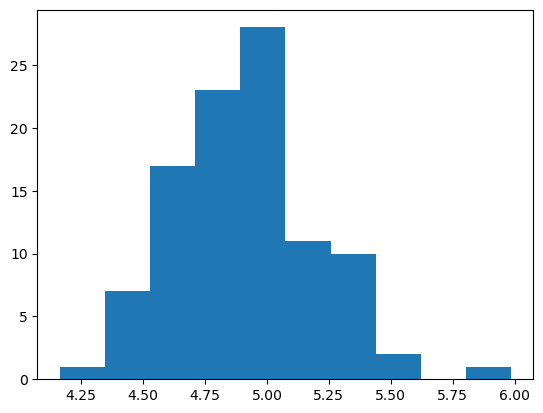

In [160]:
plt.hist(results[:, 0]);

In [139]:
np.unique(results)

array([2.91418442])

In [ ]:
results = simulate_mc(
    mu0,
    cov0,
    1000,
    1000,
    0.5,
    True,
    True
)

In [ ]:
print(*((2, 3)))

2 3


### Estimation errors

In [ ]:

# mu0 = np.random.normal(size=(3, 10))
# cov0 = np.cov(mu0)

# mu1, cov1 = generate_mu_cov(
#     mu0.mean(axis=1), cov0, 1000
# )

In [8]:
# w0 = optPort(cov0, None if minVarPortf else mu0)
# w0 = np.repeat(w0.T, w1.shape[0], axis=0)  # true allocation
# err = (w1-w0).std(axis=0).mean()
# err_d = (w1_d-w0).std(axis=0).mean()


### Numerical example

In [7]:
from scipy.linalg import block_diag


def init_mu_cov(
    block_num: int,
    block_size: int,
    block_corr: float,
    std_true: O[np.ndarray] = None
) -> T[np.ndarray, pd.DataFrame]:
    """Code snippet 7 creates a random vector of means and a random covariance
    matrix that represent a stylized version of a 50 securities portfolio,
    grouped in 10 blocks with intra-cluster correlations of 0.5. This vector
    and matrix characterize the “true” process that generates observations,
    {𝜇, 𝑉}.  We set a seed for the purpose of reproducing results across runs
    with different parameters. In practice, the pair {𝜇, 𝑉} does not need to be
    simulated, and MCOS receives {𝜇, 𝑉} as an input."""

    # create block-diagonal matrix
    corr0 = generate_correlation_block_matrix(
        block_num,
        block_size,
        block_corr
    )

    # shuffling columns and make rows correspond to columns
    cols = corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0 = corr0.loc[cols, cols].copy(deep=True)

    if std_true is None:
        std_true = np.random.uniform(.05, .2, corr0.shape[0])
    else:
        std_true = np.array([std_true]*corr0.shape[1])

    # transforming correlation matrix to covariance matrix
    cov0 = corr2cov(corr0, std_true)
    mu0 = np.random.normal(std_true, std_true, cov0.shape[0]).reshape(-1, 1)
    return mu0, cov0


def generate_correlation_block_matrix(
    block_num: int,
    block_size: int,
    block_corr: float
) -> pd.DataFrame:
    """Creates correlation block matrix from specified settings

    Args:
        block_num (int): amount of correlation clusters
        block_size (int): amount of stocks in each correlation cluster
        block_corr (float): correlation among stocks in cluster

    Returns:
        pd.DataFrame: matrix of 
            (block_num * block_size,  block_num * block_size)
        size, representing pairwise stock correlations
    """
    # creating 1 block
    block = np.ones((block_size, block_size)) * block_corr
    np.fill_diagonal(block, 1)
    # creating nBlocks from 1 block
    corr = block_diag(*([block] * block_num))
    return pd.DataFrame(corr)


Creating correlation matrix of 50 stocks, assuming, that they are clustered by
correlation. 